In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from glob import glob

In [ ]:
%cd "/content/drive/MyDrive/NCU/Dissertation/Scripts/supervised_modeling"
!python analyze_supervised.py

/usr/local/lib/python3.11/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


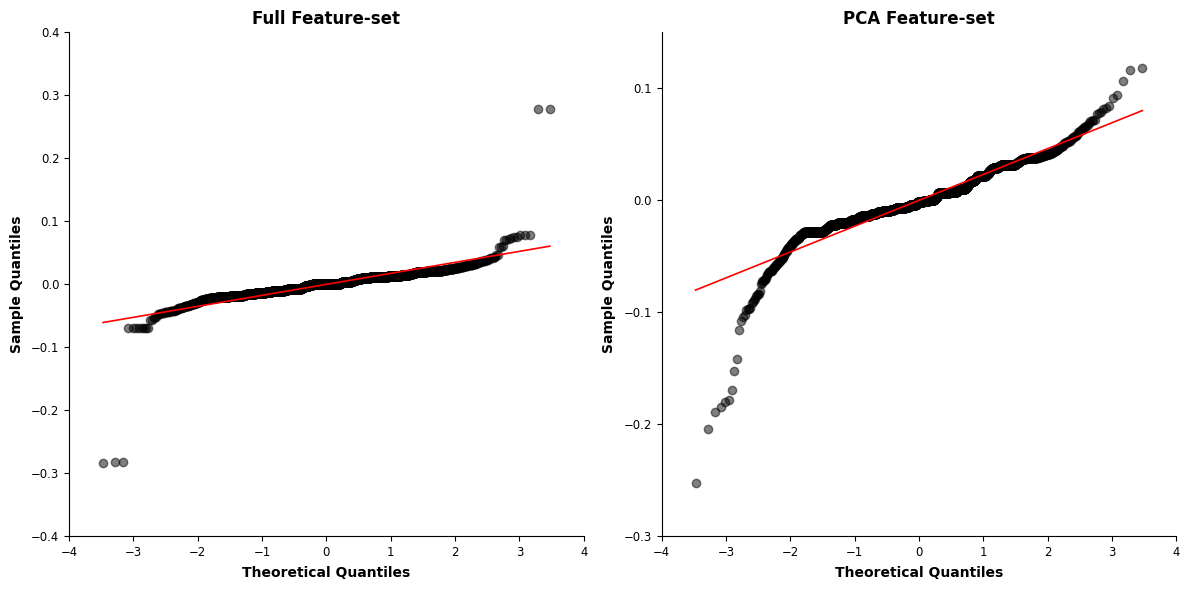

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# File paths to residual-augmented CSVs run for each metric
pca_csv = "/content/drive/MyDrive/NCU/Dissertation/Results/Supervised/PCA_run/all_features/analysis/roc_auc_with_residuals.csv"
non_pca_csv = "/content/drive/MyDrive/NCU/Dissertation/Results/Supervised/No_PCA_run/all_features/analysis/roc_auc_with_residuals.csv"

# Load and label datasets
df_pca = pd.read_csv(pca_csv)
df_pca["group"] = "PCA Feature-set"

df_non_pca = pd.read_csv(non_pca_csv)
df_non_pca["group"] = "Full Feature-set"

# Combine both
combined_df = pd.concat([df_pca, df_non_pca], ignore_index=True)

# APA style optional
plt.style.use("/content/drive/MyDrive/NCU/Dissertation/apa.mplstyle")

# Create side-by-side Q-Q plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (group, data) in zip(axes, combined_df.groupby("group")):
    sm.qqplot(data["roc_auc_residual"], line='s', ax=ax, alpha=0.5, color='black')
    ax.set_title(f"{group}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

sns.despine()
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
from scipy.stats import levene
#same process for non-pca
# Load the summary data
csv_path = "/content/drive/MyDrive/NCU/Dissertation/Results/Supervised/PCA_run/all_features/analysis/supervised__pca_summary_by_seed.csv"
df = pd.read_csv(csv_path)

# Define metrics
metrics = ["roc_auc", "accuracy", "precision", "recall", "f1"]

# Run Levene's test for each metric
levene_results = []
for model in df['model'].unique():
    sub = df[df['model'] == model]
    for metric in metrics:
        groups = [g[metric].values for _, g in sub.groupby('cluster_condition')]
        stat, pval = levene(*groups)
        levene_results.append({
            "model": model,
            "metric": metric,
            "levene_stat": stat,
            "p_value": pval
        })

levene_df = pd.DataFrame(levene_results)

# Convert to DataFrame and display
levene_df = pd.DataFrame(levene_results)
print(levene_df)



          model     metric   levene_stat   p_value
0       xgboost    roc_auc  1.220497e-01  1.000000
1       xgboost   accuracy  6.915456e-02  1.000000
2       xgboost  precision  4.546083e-01  1.000000
3       xgboost     recall  8.495010e-02  1.000000
4       xgboost         f1  4.472152e-01  1.000000
5    neural_net    roc_auc  9.350208e-01  0.673408
6    neural_net   accuracy  8.999236e-01  0.763710
7    neural_net  precision  7.430250e-01  0.978981
8    neural_net     recall  8.315644e-01  0.897410
9    neural_net         f1  7.413619e-01  0.979730
10           rf    roc_auc  1.017984e-01  1.000000
11           rf   accuracy  1.058387e-01  1.000000
12           rf  precision  2.509113e-01  1.000000
13           rf     recall  5.841618e-02  1.000000
14           rf         f1  2.477280e-01  1.000000
15  naive_bayes    roc_auc  2.236276e-04  1.000000
16  naive_bayes   accuracy  3.731797e-04  1.000000
17  naive_bayes  precision  6.227169e-03  1.000000
18  naive_bayes     recall  1.2

In [ ]:
!python two_anova.py


ANOVA Results for roc_auc:
                                  sum_sq     df            F         PR(>F)
C(model)                       4.238653    5.0  1044.517727  4.069632e-137
C(cluster_condition)           0.002604    7.0     0.458326   8.636369e-01
C(model):C(cluster_condition)  0.012858   35.0     0.452652   9.966527e-01
Residual                       0.155827  192.0          NaN            NaN

ANOVA Results for accuracy:
                                  sum_sq     df           F        PR(>F)
C(model)                       6.651352    5.0  199.148915  5.863149e-74
C(cluster_condition)           0.046795    7.0    1.000790  4.320383e-01
C(model):C(cluster_condition)  0.233983   35.0    1.000815  4.748147e-01
Residual                       1.282517  192.0         NaN           NaN

ANOVA Results for precision:
                                  sum_sq     df           F         PR(>F)
C(model)                       4.020103    5.0  778.582988  2.241362e-125
C(cluster_condition)  

In [ ]:
#one way anova pca

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load dataset
csv_path = "/content/drive/MyDrive/NCU/Dissertation/Results/Supervised/PCA_run/all_features/analysis/supervised__pca_summary_by_seed.csv"
df = pd.read_csv(csv_path)

# Metrics and models
metrics = ["roc_auc", "accuracy", "precision", "recall", "f1"]
models = df['model'].unique()

# Collect results in a dictionary
anova_summary_by_model = {}

for model_name in models:
    model_df = df[df['model'] == model_name]
    summary = []

    for metric in metrics:
        formula = f"{metric} ~ C(cluster_condition)"
        model = ols(formula, data=model_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        f_val = anova_table.loc["C(cluster_condition)", "F"]
        p_val = anova_table.loc["C(cluster_condition)", "PR(>F)"]

        summary.append({
            "Metric": metric,
            "F-Statistic": round(f_val, 4),
            "p-Value": round(p_val, 6)
        })

    anova_summary_by_model[model_name] = pd.DataFrame(summary)

# Example: Display or save the table for a specific model
model_to_display = "neural_net"  # change as needed
anova_summary_by_model


In [ ]:
#one way anova no pca
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load dataset
csv_path = "/content/drive/MyDrive/NCU/Dissertation/Results/Supervised/No_PCA_run/all_features/analysis/supervised__no_pca_summary_by_seed.csv"
df = pd.read_csv(csv_path)

# Metrics and models
metrics = ["roc_auc", "accuracy", "precision", "recall", "f1"]
models = df['model'].unique()

# Collect results in a dictionary
anova_summary_by_model = {}

for model_name in models:
    model_df = df[df['model'] == model_name]
    summary = []

    for metric in metrics:
        formula = f"{metric} ~ C(cluster_condition)"
        model = ols(formula, data=model_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        f_val = anova_table.loc["C(cluster_condition)", "F"]
        p_val = anova_table.loc["C(cluster_condition)", "PR(>F)"]

        summary.append({
            "Metric": metric,
            "F-Statistic": round(f_val, 4),
            "p-Value": round(p_val, 6)
        })

    anova_summary_by_model[model_name] = pd.DataFrame(summary)

# Example: Display or save the table for a specific model
model_to_display = "neural_net"  # change as needed
anova_summary_by_model


In [ ]:
#welch anova as needed
# Colab-ready Welch’s ANOVA drop‑in
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Update these paths for your Colab environment
pca_csv = "/content/drive/MyDrive/NCU/Dissertation/Results/Supervised/PCA_run/all_features/analysis/supervised__pca_summary_by_seed.csv"
non_pca_csv = "/content/drive/MyDrive/NCU/Dissertation/Results/Supervised/No_PCA_run/all_features/analysis/supervised__no_pca_summary_by_seed.csv"

# Load datasets
df_pca = pd.read_csv(pca_csv)
df_non_pca = pd.read_csv(non_pca_csv)

def welch_anova_by_model(df, metrics):
    """
    Performs Welch’s ANOVA (HC3 robust F-test) for each supervised model
    across cluster configurations, per metric.
    """
    results = {}
    for model in df["model"].unique():
        md = df[df["model"] == model]
        model_results = []
        for metric in metrics:
            formula = f"{metric} ~ C(cluster_condition)"
            lm = smf.ols(formula, data=md).fit()
            anova_tbl = sm.stats.anova_lm(lm, typ=2, robust='hc3')
            f_val = anova_tbl.loc["C(cluster_condition)", "F"]
            p_val = anova_tbl.loc["C(cluster_condition)", "PR(>F)"]
            model_results.append({
                "Metric": metric,
                "F‑Statistic": f_val,
                "p‑Value": p_val
            })
        results[model] = pd.DataFrame(model_results)
    return results

metrics = ["roc_auc", "accuracy", "precision", "recall", "f1"]

# Run the tests
welch_pca = welch_anova_by_model(df_pca, metrics)
welch_non_pca = welch_anova_by_model(df_non_pca, metrics)

# Example: Display PCA results for neural_net
print(" Welch’s ANOVA (PCA) – Neural Net results:")
print(welch_pca["naive_bayes"].to_string(index=False))
